# Portfolio Optimization Methods (Walk-Forward Backtesting)

Goal: compare portfolio allocation methods under realistic constraints, with transaction costs
and walk-forward backtesting (rolling train/test).


## 1. Setup


In [ ]:
from pathlib import Path
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)


## 2. Data
We download daily adjusted close prices from Yahoo Finance using `yfinance`.


In [5]:
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
START_DATE = "2018-01-01"
END_DATE = "2024-12-31"

TICKERS, START_DATE, END_DATE


(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META'], '2018-01-01', '2024-12-31')

In [6]:
prices = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=False
)["Close"]

prices = prices.dropna()
prices.head()


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2018-01-02,40.341888,59.450500,53.258099,180.161514,79.050377
2018-01-03,40.334866,60.209999,54.166733,183.388977,79.418282
2018-01-04,40.522221,60.479500,54.377140,183.051331,80.117264
2018-01-05,40.983582,61.457001,55.098194,185.553864,81.110580
2018-01-08,40.831356,62.343498,55.292725,186.973923,81.193336


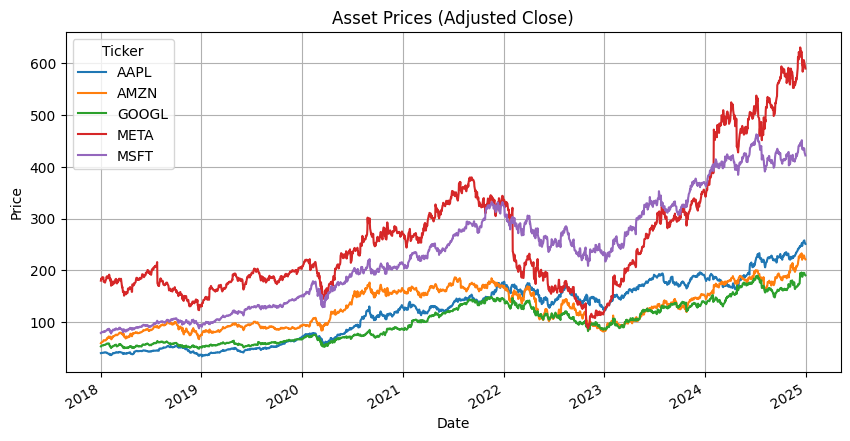

WindowsPath('../reports/figures/prices.png')

In [7]:
ax = prices.plot()
ax.set_title("Asset Prices (Adjusted Close)")
ax.set_ylabel("Price")
ax.grid(True)

plt.savefig(FIG_DIR / "prices.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "prices.png"


In [8]:
returns = prices.pct_change().dropna()
returns.head()


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2018-01-03,-0.000174,0.012775,0.017061,0.017914,0.004654
2018-01-04,0.004645,0.004476,0.003884,-0.001841,0.008801
2018-01-05,0.011385,0.016163,0.013260,0.013671,0.012398
2018-01-08,-0.003714,0.014425,0.003531,0.007653,0.001020
2018-01-09,-0.000115,0.004676,-0.001274,-0.002178,-0.000680


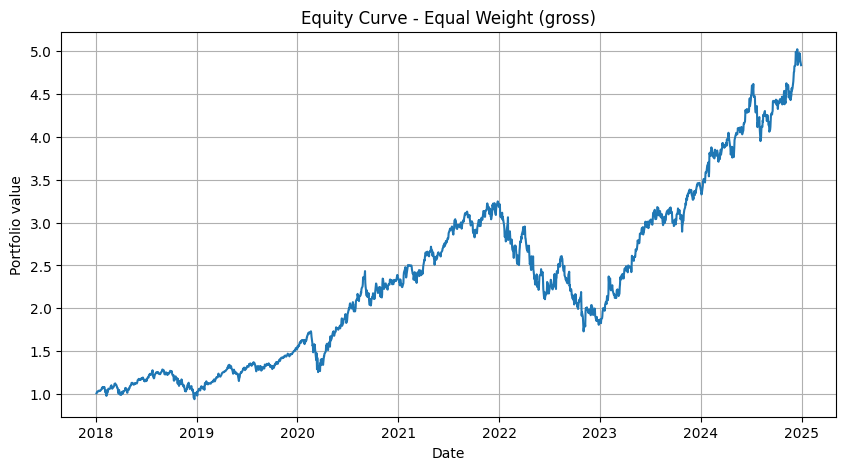

WindowsPath('../reports/figures/equity_curve.png')

In [9]:
w_eq = np.repeat(1/len(TICKERS), len(TICKERS))  # equal weights
port_ret_eq = returns @ w_eq

equity_eq = (1 + port_ret_eq).cumprod()

plt.plot(equity_eq)
plt.title("Equity Curve - Equal Weight (gross)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.grid(True)

plt.savefig(FIG_DIR / "equity_curve.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve.png"


### Performance Metrics (Baseline)

To evaluate portfolio performance, we compute the following metrics:

- **CAGR (Compound Annual Growth Rate)**: measures the annualized growth rate of the portfolio.
- **Volatility**: annualized standard deviation of portfolio returns, used as a risk proxy.
- **Sharpe Ratio**: risk-adjusted return, defined as the ratio of average excess return to volatility.
- **Maximum Drawdown**: worst peak-to-trough loss, capturing downside risk.

These metrics provide a first quantitative assessment of the baseline Equal-Weight portfolio,
before introducing optimization, constraints, and walk-forward rebalancing.
The Equal-Weight portfolio is used as a naive baseline, providing a simple benchmark against which
more sophisticated optimization methods will be compared.


In [10]:
def compute_metrics(portfolio_returns, equity_curve, freq=252):
    cagr = equity_curve.iloc[-1] ** (freq / len(equity_curve)) - 1
    vol = portfolio_returns.std() * np.sqrt(freq)
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(freq)

    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1
    max_dd = drawdown.min()

    return pd.Series({
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd
    })


metrics_eq = compute_metrics(port_ret_eq, equity_eq)
metrics_eq


CAGR            0.253270
Volatility      0.281062
Sharpe          0.944375
Max Drawdown   -0.466735
dtype: float64

At this stage, performance is evaluated using a static Equal-Weight allocation.
In the following section, we introduce portfolio optimization methods to improve
risk-adjusted returns under realistic constraints.


## 3. Portfolio Allocation Methods

We now introduce portfolio optimization techniques that aim to improve
risk-adjusted performance compared to the Equal-Weight benchmark.

In this section, portfolio weights are determined by solving optimization
problems based on historical return statistics, under realistic constraints.
The first method considered is the **Minimum Variance portfolio**.


### 3.1 Minimum Variance Portfolio

The Minimum Variance portfolio aims to construct asset weights that minimize
the overall portfolio variance, independently of expected returns.

Formally, the objective is to solve:

$$
\min_{w} \; w^\top \Sigma w
$$

subject to the following constraints:
- the portfolio is **long-only**: $w_i \ge 0$,
- portfolio weights sum to one: $\sum_i w_i = 1$,
- individual asset weights are capped to avoid excessive concentration.

This approach focuses purely on risk reduction and diversification.
It provides a natural first step beyond the Equal-Weight benchmark,
and serves as a reference for more return-oriented optimization methods.



In [12]:
from scipy.optimize import minimize

def min_variance_weights(returns, max_weight=0.4):
    """
    Compute Minimum Variance portfolio weights under long-only
    and weight cap constraints.
    """
    cov = returns.cov().values
    n = cov.shape[0]

    def portfolio_variance(w):
        return w.T @ cov @ w

    
    constraints = ({
        "type": "eq",
        "fun": lambda w: np.sum(w) - 1
    })

    
    bounds = tuple((0.0, max_weight) for _ in range(n))

    
    w0 = np.repeat(1 / n, n)

    res = minimize(
        portfolio_variance,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )

    return pd.Series(res.x, index=returns.columns)


weights_minvar = min_variance_weights(returns)
weights_minvar


Ticker
AAPL     0.2
AMZN     0.2
GOOGL    0.2
META     0.2
MSFT     0.2
dtype: float64

**Interpretation.**

In this asset universe, the Minimum Variance optimization yields weights
that are very close to an Equal-Weight allocation.

This outcome is expected when assets exhibit similar volatility levels
and are strongly correlated, especially under long-only and weight cap
constraints. In such cases, the Equal-Weight portfolio already provides
a well-diversified, low-variance allocation.

This result highlights that portfolio optimization outcomes depend
critically on the covariance structure of returns and imposed constraints,
and that optimization does not necessarily lead to highly concentrated
allocations.


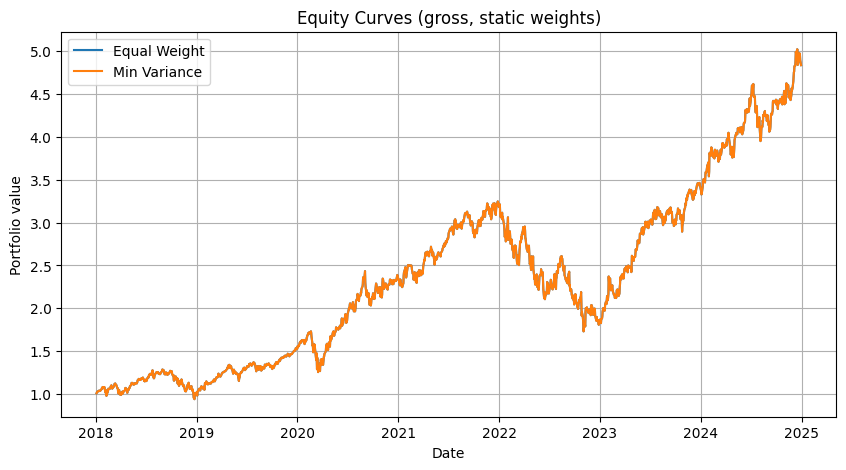

WindowsPath('../reports/figures/equity_curve_comparison.png')

In [13]:
# Portfolio returns using Minimum Variance weights (static)
port_ret_minvar = returns @ weights_minvar

# Equity curves
equity_minvar = (1 + port_ret_minvar).cumprod()

plt.figure()
plt.plot(equity_eq, label="Equal Weight")
plt.plot(equity_minvar, label="Min Variance")
plt.title("Equity Curves (gross, static weights)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

plt.savefig(FIG_DIR / "equity_curve_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve_comparison.png"


### 3.2 Maximum Sharpe Ratio Portfolio

The Maximum Sharpe portfolio seeks to maximize the portfolio's risk-adjusted
return by explicitly balancing expected returns against risk.

Formally, the optimisation problem can be written as:

$$
\max_{w}\; \frac{w^\top \mu}{\sqrt{w^\top \Sigma w}}
$$

where:
- $\mu$ denotes the vector of expected asset returns,
- $\Sigma$ is the covariance matrix of asset returns,
- $w$ is the vector of portfolio weights.

In practice, this objective corresponds to maximising the portfolio's Sharpe
ratio (assuming a zero risk-free rate). Unlike the Minimum Variance portfolio,
this method is return-driven and therefore more sensitive to estimation error
in expected returns.

The same realistic constraints are enforced:
- long-only weights: $w_i \ge 0$,
- full investment: $\sum_i w_i = 1$,
- individual weight caps to limit concentration.


In [15]:
def max_sharpe_weights(returns, max_weight=0.4, rf=0.0, freq=252, ridge=1e-6):

    mu = returns.mean().values * freq                 # annualized expected returns
    cov = returns.cov().values * freq                 # annualized covariance
    cov = cov + ridge * np.eye(cov.shape[0])          # numerical stability
    n = len(mu)

    def neg_sharpe(w):
        port_ret = w @ mu - rf
        port_vol = np.sqrt(w.T @ cov @ w)
        if port_vol <= 1e-12:
            return 1e6
        return -(port_ret / port_vol)

    
    constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1},)

    
    bounds = tuple((0.0, max_weight) for _ in range(n))

    
    w0 = np.repeat(1 / n, n)

    res = minimize(
        neg_sharpe,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )

    return pd.Series(res.x, index=returns.columns)


weights_maxsharpe = max_sharpe_weights(returns, max_weight=0.4, rf=0.0)
weights_maxsharpe


Ticker
AAPL     0.400000
AMZN     0.096326
GOOGL    0.095355
META     0.008319
MSFT     0.400000
dtype: float64

**Interpretation**

The Maximum Sharpe optimization leads to a more concentrated allocation compared
to both the Equal-Weight and Minimum Variance portfolios.

In this universe, the optimizer assigns the maximum allowed weight to the assets
with the highest estimated risk-adjusted returns (here AAPL and MSFT), while
allocating smaller weights to the remaining assets.

This behavior is expected:
- the Sharpe ratio explicitly trades off expected returns against risk,
- assets with higher historical returns tend to dominate the allocation,
- weight caps prevent excessive concentration and keep the solution realistic.

This result illustrates a key property of return-driven optimization methods:
they are highly sensitive to expected return estimates and constraints, and may
produce significantly different portfolios than risk-only approaches.


In [16]:
port_ret_maxsharpe = (returns * weights_maxsharpe).sum(axis=1)

equity_maxsharpe = (1 + port_ret_maxsharpe).cumprod()

equity_maxsharpe.head()


Date
2018-01-03    1.004798
2018-01-04    1.010993
2018-01-05    1.023578
2018-01-08    1.024307
2018-01-09    1.024300
dtype: float64

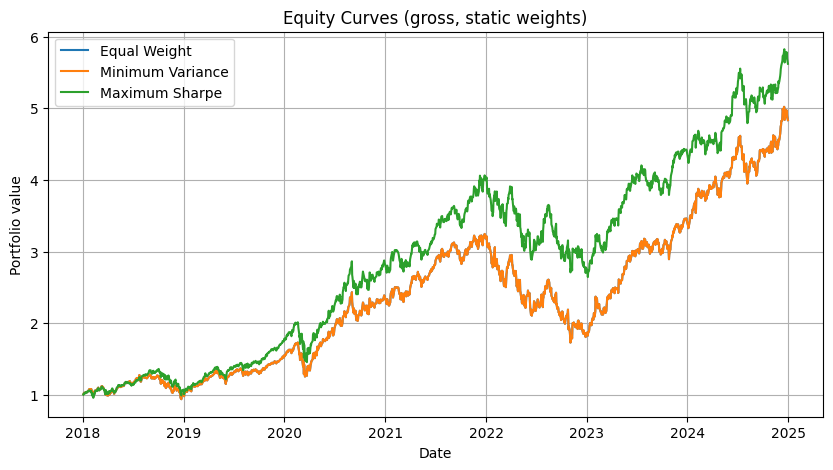

WindowsPath('../reports/figures/equity_curve_comparison.png')

In [17]:
plt.plot(equity_eq, label="Equal Weight")
plt.plot(equity_minvar, label="Minimum Variance")
plt.plot(equity_maxsharpe, label="Maximum Sharpe")

plt.title("Equity Curves (gross, static weights)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

plt.savefig(FIG_DIR / "equity_curve_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve_comparison.png"


In [18]:
metrics_eq = compute_metrics(port_ret_eq, equity_eq)
metrics_minvar = compute_metrics(port_ret_minvar, equity_minvar)
metrics_maxsharpe = compute_metrics(port_ret_maxsharpe, equity_maxsharpe)

metrics = pd.DataFrame({
    "Equal Weight": metrics_eq,
    "Minimum Variance": metrics_minvar,
    "Maximum Sharpe": metrics_maxsharpe
})

metrics


,Equal Weight,Minimum Variance,Maximum Sharpe
CAGR,0.253270,0.253270,0.280619
Volatility,0.281062,0.281062,0.270607
Sharpe,0.944375,0.944375,1.049946
Max Drawdown,-0.466735,-0.466735,-0.349138


**Quantitative comparison**

The table above highlights clear differences between the three allocation
strategies.

The Maximum Sharpe portfolio achieves the highest compound annual growth rate
and the best Sharpe ratio, while also exhibiting a significantly smaller maximum
drawdown than the Equal-Weight and Minimum Variance portfolios.

In contrast, the Equal-Weight and Minimum Variance strategies deliver nearly
identical performance in this asset universe, suggesting that under strong
correlations and binding constraints, risk-only optimization provides limited
benefits over naive diversification.

While these results appear favorable for the Maximum Sharpe portfolio, it is
important to note that all optimizations are performed using full-sample
historical estimates. This raises concerns about estimation error and
overfitting, motivating the introduction of walk-forward rebalancing in the
next section.
